In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# load the netcdf dataset
nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly.nc')

In [3]:
# bounding box
lat_bounds = slice(44.75, 46.65)
lon_bounds = slice(8.5, 11.25)

In [4]:
# load the nh3 layer in the region specified by the bounding box
nh3 = nh3_nc.agl.sel(lat=lat_bounds, lon=lon_bounds)

In [6]:
shape = gpd.read_file('../resources/regione/regione_2015.shp')
shape.head()

,CODICE,NOME,SHAPE_AREA,SHAPE_LEN,geometry
0,03,REGIONE LOMBARDIA,2.386795e+10,1.535219e+06,"MULTIPOLYGON (((460668.530 5015498.348, 460677..."


In [8]:
def plot_shapefile(shapefile, epsg=4326, title='', xlabel='', ylabel=''):

    shapefile.to_crs(epsg=epsg, inplace=True)
    fig, ax = plt.subplots(1)
    ax = shapefile.plot(axes=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

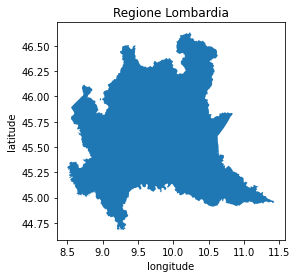

In [9]:
plot_shapefile(shape, epsg=4326, title='Regione Lombardia', xlabel='longitude', ylabel='latitude')

In [28]:
def filter_grid_on_shapefile(lats, lons, shp, plot_grid=False, plot_filter=False):

    # create the latitudes/longitudes grid
    coords = [(lat, lon) for lat in lats for lon in lons]

    lats = [coord[0] for coord in coords]
    lons = [coord[1] for coord in coords]   

    if plot_grid: 
        plt.figure()
        plt.title('Observations Grid')
        plt.xlabel('longitutde')
        plt.ylabel('latitude')
        plt.scatter(lons, lats, c='r')
        plt.show()
    
    # consider only the points inside the shape
    grid = [
            (round(lat, 2), round(lon, 2)) 
            for lat, lon in zip(lats, lons) 
                if shp.geometry.contains(Point(lon, lat)).bool()
            ]

    if plot_filter:
        lats = [coord[0] for coord in grid]
        lons = [coord[1] for coord in grid]
        plt.figure()
        shp.plot()
        plt.scatter(lons, lats, c='r')
        plt.title('Filtered Observations Grid')
        plt.xlabel('longitutde')
        plt.ylabel('latitude')
        plt.show()

    return grid

In [36]:
def filter_data_on_shapefile(data, lats, lons, shp, plot_grid=False, plot_filter=False):

    lats = [round(lat, 2) for lat in lats.to_series().tolist()]
    lons = [round(lon, 2) for lon in lons.to_series().tolist()]

    result = np.ones((252, len(lats), len(lons)))
    result.fill(np.nan)

    grid = filter_grid_on_shapefile(lats=lats, lons=lons, shp=shp, plot_grid=plot_grid, plot_filter=plot_filter)

    for lat_idx, lat in enumerate(lats):
        for lon_idx, lon in enumerate(lons):

            if (lat, lon) in grid:
                for time_idx in range(len(data.time.to_series().tolist())):
                    result[time_idx][lat_idx][lon_idx] = data[time_idx, lat_idx, lon_idx].values
    return result

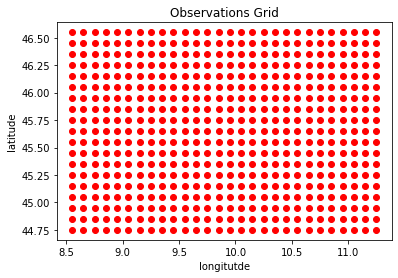

<Figure size 432x288 with 0 Axes>

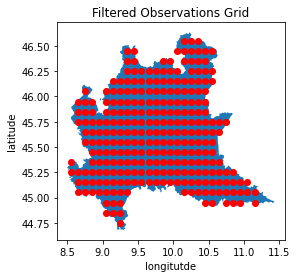

In [37]:
# filter the time series inside the shapefile
data = filter_data_on_shapefile(nh3, lats = nh3.lat, lons = nh3.lon, shp=shape, plot_grid=True, plot_filter=True)

In [59]:
lats = nh3.lat.to_series().tolist()
lons = nh3.lon.to_series().tolist()
times = nh3.time.to_series().tolist()

In [60]:
filtered_nh3 = xr.DataArray(data, coords=[times, lats , lons], dims=['time', 'lat', 'lon'])   
filtered_nh3.attrs = nh3.attrs

In [61]:
filtered_nh3_dataset = xr.Dataset(
    {
    'agl': (['time', 'lat', 'lon'], data)
    },
    coords = {
        'lat': lats,
        'lon': lons,
        'time': times
    }
)

In [62]:
filtered_nh3_dataset.to_netcdf('CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc')